# **Imports and importing the data**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
rateMyProfData = pd.read_csv('Cleaned_UW_RMP.csv')
rateMyProfData.head()

,Review-Body,Date,Course-Name,Course-Number,For-Credit,Attendance,Take-Again,Grade,Textbook,Quality,Difficulty
0,"It's not hard class, but don't expect the 4.0....",2015-03-08,BUS,340.0,Yes,NaN,NaN,NaN,Yes,2.0,2.0
1,Syllabus was clear on what the daily homework ...,2016-02-21,BCUSP,202.0,Yes,NaN,NaN,NaN,Yes,2.5,3.0
2,Bridge is the coolest prof I've ever had. His ...,2023-11-20,BME,221.0,Yes,Not Mandatory,Yes,NaN,Yes,5.0,2.0
3,Bridge makes it abundantly clear what you need...,2020-08-22,ME,341.0,Yes,Not Mandatory,Yes,NaN,Yes,5.0,3.0
4,One of the best professors I have ever had. Tr...,2020-04-22,BENGR,321.0,Yes,Mandatory,Yes,NaN,Yes,5.0,3.0


# **Data Exploration**

## **Further Data Checking and Cleaning**

In [3]:
# See the null values by each row
rateMyProfData.isnull().sum()

Review-Body         1
Date                0
Course-Name        83
Course-Number     522
For-Credit       7905
Attendance       7921
Take-Again       8836
Grade            8970
Textbook         2649
Quality             0
Difficulty          0
dtype: int64

In the above cell, we can see there are a significant number of null values in the columns that are optional for users when leaving a review. Due to the sheer number of null values, This information is not neccessary or useful. We will drop these for the rest of our analysis.

In [4]:
rateMyProfData.drop(columns=['For-Credit', 
                         'Attendance', 
                         'Take-Again', 
                         'Grade', 
                         'Textbook'], inplace=True)

Further we need to deal with the null values that are still in place. For the review body, there is only one null value, and the review body is necessary so we will drop this row.

In [5]:
rateMyProfData = rateMyProfData.dropna(subset=['Review-Body'])

And finally, we chose to drop rows with null values course name and number, to keep the data from those for some interesting analysis later.

In [6]:
rateMyProfData = rateMyProfData.dropna(subset=['Course-Name', 'Course-Number'])
rateMyProfData['Course-Number'] = [str(num)[0] for num in rateMyProfData['Course-Number']] 
# user input data is all over the place, 
# take the first digit for the class year, ie 1 = 100 level, 4 = 400 level.


## **Data Analysis**

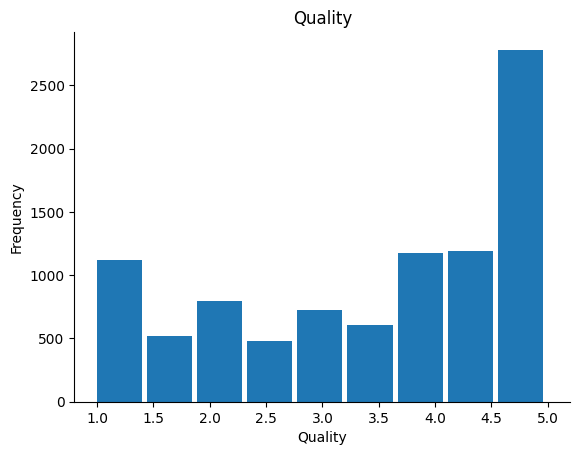

In [7]:
rateMyProfData['Quality'].plot(kind='hist', bins=9, title='Quality', align='mid', width=0.4)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Quality')
plt.ylabel('Frequency')

plt.show()

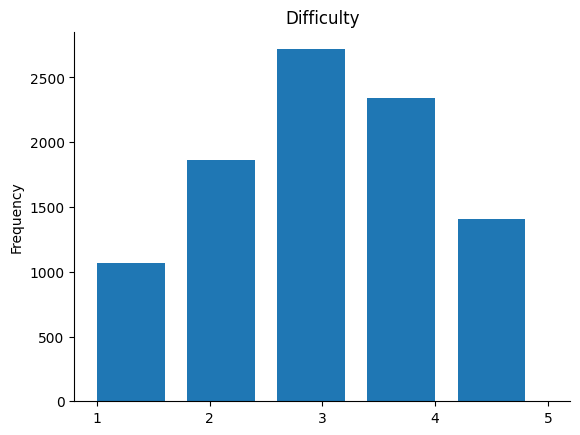

In [8]:
rateMyProfData['Difficulty'].plot(kind='hist', bins=5, title='Difficulty', width=0.6)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xticks(range(1, 6))

plt.show()

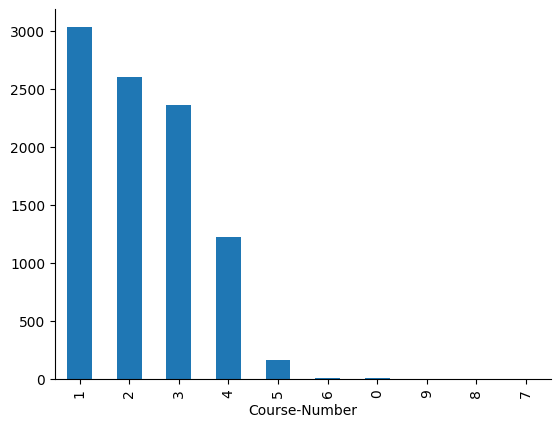

In [9]:
rateMyProfData['Course-Number'].value_counts().plot(kind='bar')
plt.gca().spines[['top', 'right',]].set_visible(False)

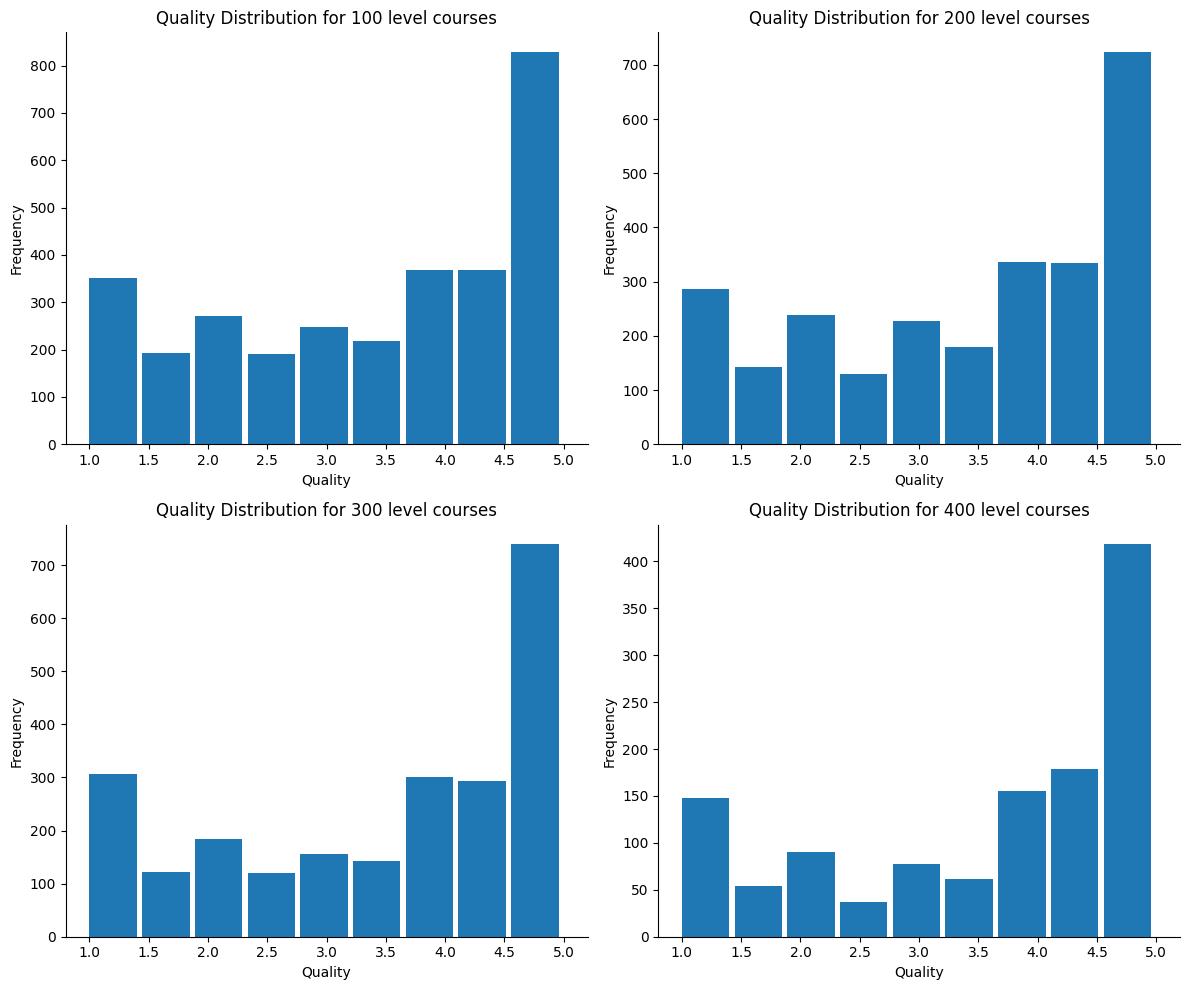

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, course_number in enumerate([1, 2, 3, 4]):
  ax = axes[i // 2, i % 2]
  course_data = rateMyProfData[rateMyProfData['Course-Number'] == str(course_number)]
  course_data['Quality'].plot(kind='hist', bins=9, title=f'Quality Distribution for {course_number}00 level courses', ax=ax, width=0.4)
  ax.spines[['top', 'right']].set_visible(False)
  ax.set_xlabel('Quality')
  ax.set_ylabel('Frequency')

plt.tight_layout()

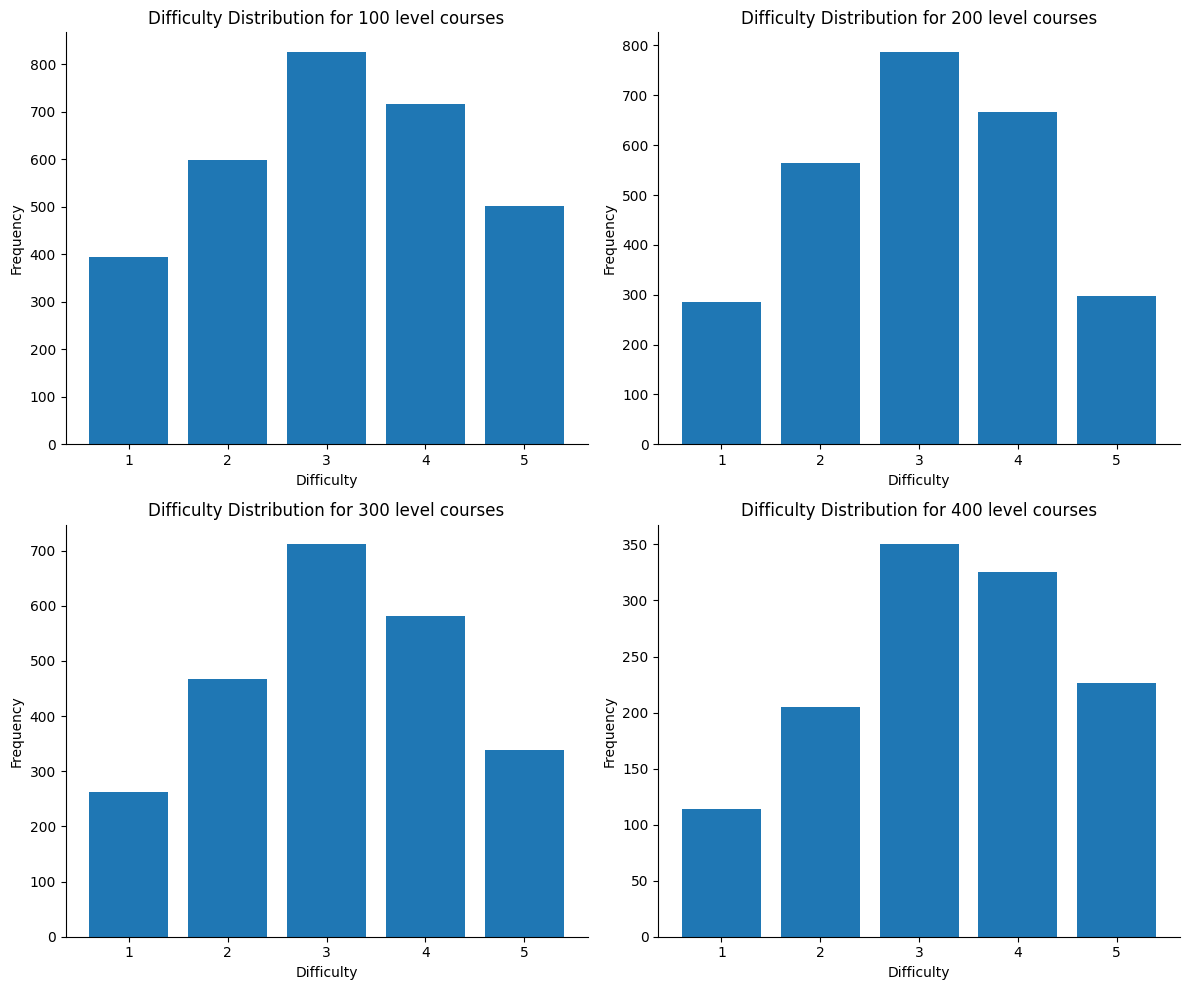

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, course_number in enumerate([1, 2, 3, 4]):
    ax = axes[i // 2, i % 2]
    course_data = rateMyProfData[rateMyProfData['Course-Number'] == str(course_number)]
    difficulty_values = course_data['Difficulty']
    bin_edges = np.arange(0.5, 6, 1)  # Calculate bin edges manually to center bars
    ax.hist(difficulty_values, bins=bin_edges, align='mid', rwidth=0.8)
    ax.set_title(f'Difficulty Distribution for {course_number}00 level courses')
    ax.set_xlabel('Difficulty')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(1, 6))
    ax.set_xticklabels(range(1, 6))
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()

In [12]:
course_counts = rateMyProfData['Course-Name'].value_counts()
for course_name, count in course_counts.items():
  if count > 100:
    print(f"{course_name}: {count}")

CHEM: 602
BBUS: 539
BIS: 461
PSYCH: 428
MATH: 379
PHYS: 379
COM: 354
SOC: 310
ECON: 300
ENGL: 255
GEOG: 239
ACCTG: 199
BCUSP: 176
PHIL: 166
CSS: 146
POLS: 137
ENG: 128
CSE: 123
ESRM: 121
BIOL: 120
ITAL: 113


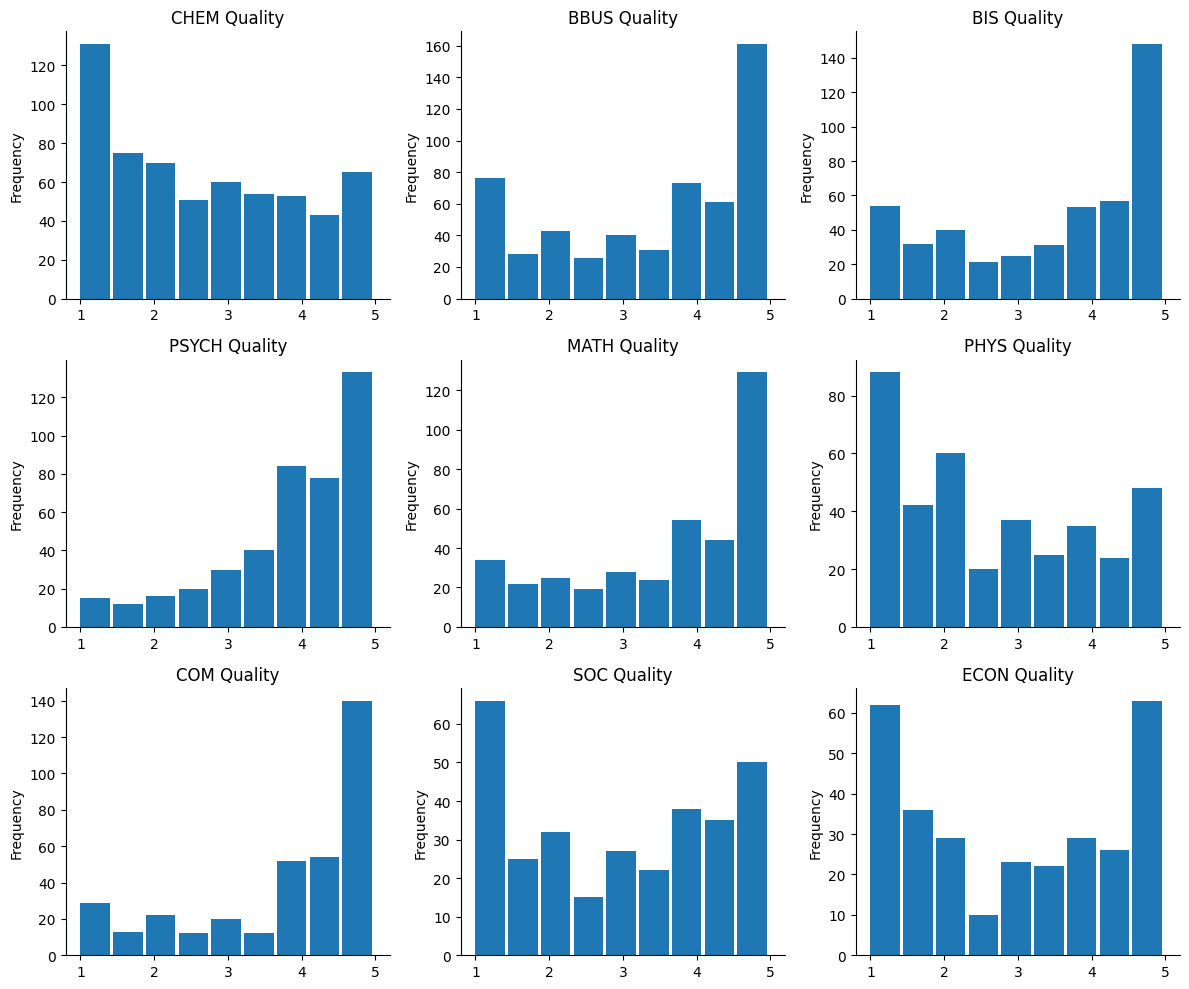

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i, course_name in enumerate(course_counts.index[:9]):
  ax = axes[i // 3, i % 3]
  course_data = rateMyProfData[rateMyProfData['Course-Name'] == course_name]
  course_data['Quality'].plot(kind='hist', bins=9, title=f'{course_name} Quality', ax=ax, width=0.4)
  ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()

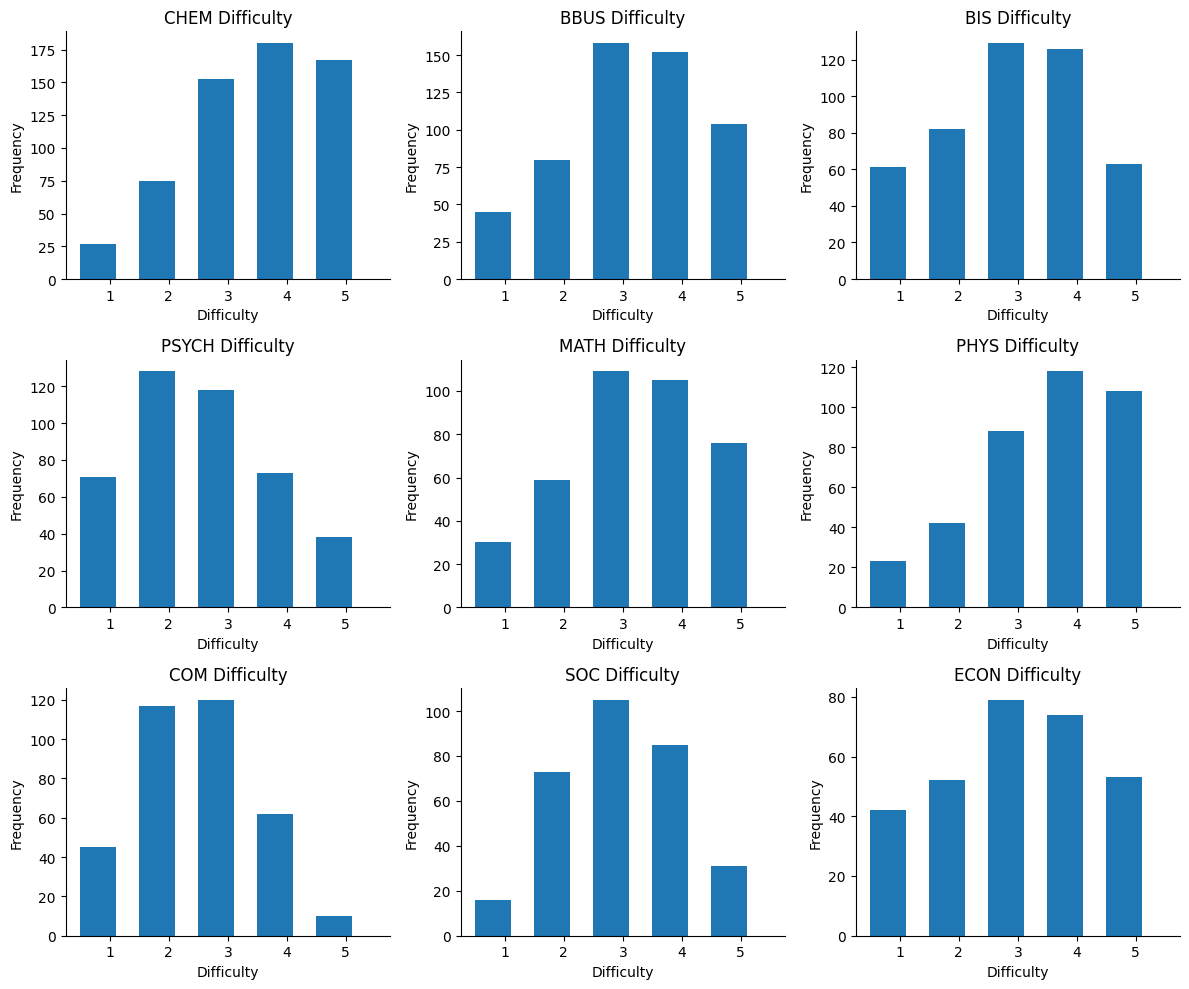

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i, course_name in enumerate(course_counts.index[:9]):
  ax = axes[i // 3, i % 3]
  course_data = rateMyProfData[rateMyProfData['Course-Name'] == course_name]
  bin_edges = np.arange(0.5, 6, 1)  # Calculate bin edges manually to center bars
  course_data['Difficulty'].plot(kind='hist', bins=bin_edges, title=f'{course_name} Difficulty', ax=ax, width=0.6)
  ax.spines[['top', 'right']].set_visible(False)
  ax.set_xlabel('Difficulty')
  ax.set_ylabel('Frequency')
  ax.set_xticks(range(1, 6))
  ax.set_xticklabels(range(1, 6))

plt.tight_layout()

Possible analysis with date

# **Prediction of Quality and Difficulty**

## **Basic Machine Learning**

To start creating a prediction of quality and difficulty for the reviews, we need to do some pre-processing on the review bodies. Our goal is to compare a basic Machine Learning model here to a more robust transformer. We have chosen to use a linear regression model, and to compare it to a BERT model.

### Review Pre-Processing for Logistic Regression Model

In [15]:
# Send to lowercase
rateMyProfData['cleanReview'] = rateMyProfData['Review-Body'].str.lower()
# remove numbers
rateMyProfData['cleanReview'] = rateMyProfData['cleanReview'].apply(lambda x: re.sub(r'\d+', '', x)) 
# remove punctuation
rateMyProfData['cleanReview'] = rateMyProfData['cleanReview'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) 
# remove extra spaces
rateMyProfData['cleanReview'] = rateMyProfData['cleanReview'].apply(lambda x: ' '.join([token for token in x.split()]))
# remove stop words
stop = set(stopwords.words('english'))
rateMyProfData['cleanReview'] = rateMyProfData['cleanReview'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

rateMyProfData['cleanReview'].head()

0    hard class dont expect isnt clear expected syl...
1    syllabus clear daily homework huge help quarte...
2    bridge coolest prof ive ever joy passion subje...
3    bridge makes abundantly clear need know get go...
4        one best professors ever truly cares students
Name: cleanReview, dtype: object

#### Word Tokenization

In [16]:
rateMyProfData['review_tokens'] = rateMyProfData['cleanReview'].apply(lambda x: word_tokenize(x))
rateMyProfData['review_tokens'].head()

0    [hard, class, dont, expect, isnt, clear, expec...
1    [syllabus, clear, daily, homework, huge, help,...
2    [bridge, coolest, prof, ive, ever, joy, passio...
3    [bridge, makes, abundantly, clear, need, know,...
4    [one, best, professors, ever, truly, cares, st...
Name: review_tokens, dtype: object

#### POS Tagging

In [17]:
rateMyProfData['review_tokens'] = rateMyProfData['review_tokens'].apply(lambda x: nltk.pos_tag(x))
rateMyProfData['review_tokens'].head()

0    [(hard, JJ), (class, NN), (dont, NN), (expect,...
1    [(syllabus, JJ), (clear, JJ), (daily, JJ), (ho...
2    [(bridge, NN), (coolest, JJS), (prof, NN), (iv...
3    [(bridge, NN), (makes, VBZ), (abundantly, RB),...
4    [(one, CD), (best, JJS), (professors, NNS), (e...
Name: review_tokens, dtype: object

#### Lemmatizing

In [18]:
# need this to get correct POS tag for nltk lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [19]:
lemmatizer = WordNetLemmatizer()

rateMyProfData['review_tokens'] = rateMyProfData['review_tokens'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                                                                        if get_wordnet_pos(tag)
                                                                        else lemmatizer.lemmatize(word)
                                                                        for word, tag in x])
rateMyProfData['review_tokens'].head()

0    [hard, class, dont, expect, isnt, clear, expec...
1    [syllabus, clear, daily, homework, huge, help,...
2    [bridge, cool, prof, ive, ever, joy, passion, ...
3    [bridge, make, abundantly, clear, need, know, ...
4    [one, best, professor, ever, truly, care, stud...
Name: review_tokens, dtype: object

### Bag of Words

In [20]:
# Change it to a list of strings so BoW can operate correctly
rateMyProfData['cleanReview'] = rateMyProfData['review_tokens'].apply(lambda x: ' '.join(x))
rateMyProfData['cleanReview'].head()

0    hard class dont expect isnt clear expect sylla...
1    syllabus clear daily homework huge help quarte...
2    bridge cool prof ive ever joy passion subject ...
3    bridge make abundantly clear need know get goo...
4           one best professor ever truly care student
Name: cleanReview, dtype: object

### Creating the Linear Regression Models

In [21]:
# Split the data into test and train for both predictions
X_train_Qual, X_test_Qual, y_train_Qual, y_test_Qual = train_test_split(rateMyProfData['cleanReview'], 
                                                                        rateMyProfData['Quality'], 
                                                                        test_size=0.2, 
                                                                        random_state=42)
X_train_Diff, X_test_Diff, y_train_Diff, y_test_Diff = train_test_split(rateMyProfData['cleanReview'], 
                                                                        rateMyProfData['Difficulty'], 
                                                                        test_size=0.2, 
                                                                        random_state=42)

In [22]:
# Get the bodies for analysis later
X_test_Qual_Orig = X_test_Qual
X_test_Diff_Orig = X_test_Diff

In [23]:
vectorizer_Qual = CountVectorizer()
regressor_Qual = LinearRegression()

vectorizer_Diff = CountVectorizer()
regressor_Diff = LinearRegression()

# Convert the text to a bag-of-words representation
X_train_Qual = vectorizer_Qual.fit_transform(X_train_Qual)
X_test_Qual = vectorizer_Qual.transform(X_test_Qual)

regressor_Qual.fit(X_train_Qual, y_train_Qual)
y_pred_Qual = regressor_Qual.predict(X_test_Qual)

X_train_Diff = vectorizer_Diff.fit_transform(X_train_Diff)
X_test_Diff = vectorizer_Diff.transform(X_test_Diff)

regressor_Diff.fit(X_train_Diff, y_train_Diff)
y_pred_Diff = regressor_Diff.predict(X_test_Diff)

### Analyzing the Linear Regression performances

#### Quality Analysis

In [24]:
mse = mean_squared_error(y_test_Qual, y_pred_Qual)
print("Quality Mean Squared Error:", mse)

Quality Mean Squared Error: 46.801004388928476


In [25]:
example_index = 1
specific_instance = X_test_Qual[example_index]
prediction = regressor_Qual.predict(specific_instance)
actual_label = y_test_Qual.iloc[example_index]
print("Cleaned review body at index:", example_index)
print(X_test_Qual_Orig.iloc[example_index])
print("Actual X_test_Qual[2] label:", actual_label)
print("Prediction for X_test_Qual[2]:", prediction)

Cleaned review body at index: 1
interesting lecture movie clip professor passionate subject matter
Actual X_test_Qual[2] label: 3.5
Prediction for X_test_Qual[2]: [4.22383753]


In [26]:
example_index = 4
specific_instance = X_test_Qual[example_index]
prediction = regressor_Qual.predict(specific_instance)
actual_label = y_test_Qual.iloc[example_index]
print("Cleaned review body at index:", example_index)
print(X_test_Qual_Orig.iloc[example_index])
print("Actual X_test_Qual[2] label:", actual_label)
print("Prediction for X_test_Qual[2]:", prediction)

Cleaned review body at index: 4
professor giffard run rome program uw every class nothing best say experience one memorable life knowledge appreciation rome inspire thanks everything
Actual X_test_Qual[2] label: 5.0
Prediction for X_test_Qual[2]: [21.8190017]


As we can see, the performance is quite terrible. For a range of labels from 0.5 - 5.0, a mean squared error of almost 47 is very bad. 

Further the prediction at index 2 above, isnt too far off, but the prediction at index 4 is way out of scope. We can see from the review bodies that the review at index 4 contains very positive words, it is likely that the regressor is seeing a highly positive review and correlating a little too heavily, also not realizing that the max value is 5.

One thing we found upon researching is to clip the prediction to between 0.5 and 5.0 for quality to eliminate over-estimating highly praising reviews. While this does not actually help the Machine Learning model, it does help the usefulness of the prediction, and the mean-squared error. It is much better now at 4.6, but 4.6 is still quite bad for a range of possible values between 0.5 and 5.0.

In [27]:
y_pred_Qual = np.clip(y_pred_Qual, 0.5, 5.0)

qual_mse = mean_squared_error(y_test_Qual, y_pred_Qual)
print("Quality Mean Squared Error after clipping:", qual_mse)

Quality Mean Squared Error after clipping: 4.619695166916413


#### Difficulty Analysis

In [28]:
mse = mean_squared_error(y_test_Diff, y_pred_Diff)
print("Difficulty Mean Squared Error:", mse)

Difficulty Mean Squared Error: 46.01635489342489


In [29]:
example_index = 7
specific_instance = X_test_Diff[example_index]
prediction = regressor_Diff.predict(specific_instance)
actual_label = y_test_Diff.iloc[example_index]
print("Cleaned review body at index:", example_index)
print(X_test_Diff_Orig.iloc[example_index])
print("Actual X_test_Diff[2] label:", actual_label)
print("Prediction for X_test_Diff[2]:", prediction)

Cleaned review body at index: 7
super interest lot fun really great answer confuse philosophical question class structure really well make really enjoy philosophy
Actual X_test_Diff[2] label: 2.0
Prediction for X_test_Diff[2]: [1.71162465]


In [30]:
example_index = 6
specific_instance = X_test_Diff[example_index]
prediction = regressor_Diff.predict(specific_instance)
actual_label = y_test_Diff.iloc[example_index]
print("Cleaned review body at index:", example_index)
print(X_test_Diff_Orig.iloc[example_index])
print("Actual X_test_Diff[2] label:", actual_label)
print("Prediction for X_test_Diff[2]:", prediction)

Cleaned review body at index: 6
dont ask open book test really hard even though may say easy would note allow
Actual X_test_Diff[2] label: 5.0
Prediction for X_test_Diff[2]: [1.5091838]


Just as before with quality, the performance of the difficulty model is very similarly terrible. This model has a mean-squared error of about 46, which is slightly better. 

The prediction at index 7 above is pretty close, even though the word confuse is in the review, which we thought would increase the difficulty prediction. 

At index 6 also above is even more interesting, even though the review conatains negative phrasing such as dont ask, and contains the word hard, the model predictied a difficulty score of 1.5 relating to very easy, while the true label was 5 out of 5 difficulty. In this review, it is likely because the context of the word easy. In the review to a human reader it seems that the intent of the word easy here is the author contradicting what others have said, and disagreeing with it.

Clipping the prediction to between 1 and 5 for quality to eliminate out of bounds reviews helped here again. Similarly, it does not help the prediction model, but just the output and mean-squared error. It is much better now at 3.7, but again 3.7 is still quite bad for a range of possible values between 1 and 5.

In [31]:
y_pred_Diff = np.clip(y_pred_Diff, 1, 5)

diff_mse = mean_squared_error(y_test_Diff, y_pred_Diff)
print("Difficulty Mean Squared Error after clipping:", diff_mse)

Difficulty Mean Squared Error after clipping: 3.709203801773923


## **BERT NLP Model**

### Pre-Processing for BERT Model

For out BERT model, we decided to use the bert-base-uncased because we should not have any need for a cased version, as there are very few NER cases in the review texts. For this context, the base BERT should be enough without further training as the review body is normal language, and we are not trying to do anything out of the ordinary to it.

In [32]:
review_texts = rateMyProfData['Review-Body'].tolist()

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Use the BERT uncased transformer to get the reviews into a tokenized uniform format for the model to make predictions on

inputs = tokenizer(review_texts, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
Quality_labels = torch.tensor(rateMyProfData['Quality'].tolist(), dtype=torch.float)
Difficulty_labels = torch.tensor(rateMyProfData['Difficulty'].tolist(), dtype=torch.float)

In [34]:
# Split the data for two predictions

train_ids_Qual, test_ids_Qual, train_mask_Qual, test_mask_Qual, train_labels_Qual, test_labels_Qual = train_test_split(
    input_ids, attention_mask, Quality_labels, test_size=0.2, random_state=42
)

train_ids_Diff, test_ids_Diff, train_mask_Diff, test_mask_Diff, train_labels_Diff, test_labels_Diff = train_test_split(
    input_ids, attention_mask, Difficulty_labels, test_size=0.2, random_state=42
)

In [35]:
# Create a class to more easily use functions to access data later.
class ReviewDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


In [36]:
batch_size = 12

# Create Quality datasets
Qual_train_dataset = ReviewDataset(train_ids_Qual, train_mask_Qual, train_labels_Qual)
Qual_test_dataset = ReviewDataset(test_ids_Qual, test_mask_Qual, test_labels_Qual)

# Create Quality dataloaders
Qual_train_loader = DataLoader(Qual_train_dataset, batch_size=batch_size, shuffle=True)
Qual_test_loader = DataLoader(Qual_test_dataset, batch_size=batch_size, shuffle=False)

# Create Difficulty datasets
Diff_train_dataset = ReviewDataset(train_ids_Diff, train_mask_Diff, train_labels_Diff)
Diff_test_dataset = ReviewDataset(test_ids_Diff, test_mask_Diff, test_labels_Diff)

# Create Difficulty dataloaders
Diff_train_loader = DataLoader(Diff_train_dataset, batch_size=batch_size, shuffle=True)
Diff_test_loader = DataLoader(Diff_test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
print(len(Diff_train_dataset))
print(len(Diff_train_loader))

7517
627


### Create and Train the Model

In [38]:
class BertForRegression(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super(BertForRegression, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        reg_output = self.regressor(cls_output)
        return reg_output

# Instantiate the models
Qual_model = BertForRegression()
Diff_model = BertForRegression()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()


In [39]:
if not os.path.isfile('qual_model.pth'):
    torch.cuda.empty_cache()

    # Define loss function and optimizer
    Qual_optimizer = optim.Adam(Qual_model.parameters(), lr=1e-5)

    # Train the model
    Qual_model.to(device)

    Qual_model.train()
    for epoch in range(3):  # Number of epochs
        for batch_idx, batch in enumerate(Qual_train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            
            Qual_optimizer.zero_grad()
            outputs = Qual_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            Qual_optimizer.step()
            
            print(f"Epoch {epoch}, Batch Status: {batch_idx}/{len(Qual_train_loader)}, Loss: {loss.item()}")
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
    torch.save(Qual_model.state_dict(), 'qual_model.pth')

In [40]:
if not os.path.isfile('diff_model.pth'):
    torch.cuda.empty_cache()

    # Define optimizer
    Diff_optimizer = optim.Adam(Diff_model.parameters(), lr=1e-5)

    # Train the model
    Diff_model.to(device)

    Diff_model.train()
    for epoch in range(3):  # Number of epochs
        for batch_idx, batch in enumerate(Diff_train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            
            Diff_optimizer.zero_grad()
            outputs = Diff_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            Diff_optimizer.step()
            
            print(f"Epoch {epoch}, Batch Status: {batch_idx}/{len(Diff_train_loader)}, Loss: {loss.item()}")
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
    torch.save(Diff_model.state_dict(), 'diff_model.pth')

In [41]:
torch.cuda.empty_cache()
qual_model = BertForRegression()
qual_model.load_state_dict(torch.load('qual_model.pth'))
qual_model.eval()
qual_model = qual_model.to(device)
test_loss = 0
with torch.no_grad():
    for batch_idx, batch in enumerate(Qual_test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)
        
        outputs = qual_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    qual_avg_test_loss = test_loss / len(Qual_test_loader)
    print(f"Quality Test Loss: {qual_avg_test_loss}")
    if batch_idx % 10 == 0:
        torch.cuda.empty_cache()

Quality Test Loss: 0.6186219492725505


In [42]:
diff_model = BertForRegression()
diff_model.load_state_dict(torch.load('diff_model.pth'))
diff_model.eval()
diff_model = diff_model.to(device)
test_loss = 0
with torch.no_grad():
    for batch_idx, batch in enumerate(Diff_test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)
        
        outputs = diff_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    diff_avg_test_loss = test_loss / len(Diff_test_loader)
    print(f"Difficulty Test Loss: {diff_avg_test_loss}")
    if batch_idx % 10 == 0:
        torch.cuda.empty_cache()

Difficulty Test Loss: 1.0040646133718976


From the above, we have trained a BERT regression model to predict both quality and difficulty based on the same dataset as the linear regression model. The test loss for quality and difficulty respectively is .62 and 1.00. these values are not perfect, but actually quite good and within the scopes of 0.5-5.0 and 1-5. They are performing well predicting the quality and difficulty scores based only on the review text.

## **Comparing the Two Models**

Because we defined the criterion as "criterion = nn.MSELoss()" the comparison between the performance of the two models is straightforward, as the scores are both calculated using mean-squared error.

In [43]:
print(f"BERT model Difficulty Test Loss: {diff_avg_test_loss}")
print(f"BERT model Quality Test Loss: {qual_avg_test_loss}")

BERT model Difficulty Test Loss: 1.0040646133718976
BERT model Quality Test Loss: 0.6186219492725505


In [44]:
print(f"Linear regression model Difficulty Test MSE: {diff_mse}")
print(f"Linear regression model Quality Test MSE: {qual_mse}")

Linear regression model Difficulty Test MSE: 3.709203801773923
Linear regression model Quality Test MSE: 4.619695166916413


The BERT model performed significantly better in both predictions, especially before adding the clipping to the initial regression model.

In [45]:
improvement_percentage = ((diff_mse - diff_avg_test_loss) / diff_mse) * 100
print(f"BERT model performed {improvement_percentage:.2f}% better in difficulty predictions")

improvement_percentage = ((qual_mse - qual_avg_test_loss) / qual_mse) * 100
print(f"BERT model performed {improvement_percentage:.2f}% better in quality predictions")


BERT model performed 72.93% better in difficulty predictions
BERT model performed 86.61% better in quality predictions


These results are not surprising at all, as the BERT model is much more robust than bag of words and traditional linear regression models.

# Toxicity Model Predictions
Here, we analyze our dataset for toxic reviews. We'll use three approaches: a classical ML approach using Naive Bayes, a standard transformer approach using RoBERTa, and an experimental transformer approach using ELECTRA for seeing if Replaced Token Detection might help with detecting toxicity. 

ML Portion: Find Toxicity Using Naive Bayes 

In [46]:
# Naive Bayes predictions are already done and processed external to this notbook. The results and respective notebook can be found in the toxicity models folder. 

Roberta Toxicity Predictions

In [47]:
!pip install openpyxl

import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('toxicity_models/RoBERTa Model and code/fine_tuned_roberta')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'


global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['Review-Body']
    if pd.isnull(text_to_predict):
      text_to_predict = "No Comments" 
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if np.abs(probabilities[0]) > 0.538298547 else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)


    return binary_label, probabilities[0]
    
twitch_df = pd.read_csv('Cleaned_UW_RMP.csv')
print(f"Total length of test: {len(twitch_df)}")

# Apply the prediction function to each row in the DataFrame
roberta_predictions_df = twitch_df.apply(predict_label, axis=1, result_type='expand')

Total length of test: 10002
It's not hard class, but don't expect the 4.0. She isn't clear about what is expected and the syllabus changed multiple times over the quarter. You can tell she doesn't take business students seriously and makes you feel awkward about your responses which really discourages participation.
0.5382911
0
Syllabus was clear on what the daily homework was, which was a huge help for the quarter! Would recommend uploading her powerpoint presentations before her class to stay keep up with lectures; what she says verbally shows up on the midterms! Also reading the textbook helped!! Overall, good professor but her lectures are a bore.
0.538291
0
Bridge is the coolest prof I've ever had. His joy and passion of the subjects he teaches is next level. He's always telling stories that relate to the subject in interesting ways. Easy grader and really cares that the students fully understand, and succeed in his course. Clear and fair expectations, do the homeworks and you'll 

Electra Toxicity Predictions

In [48]:
!pip install openpyxl
import pandas as pd
import numpy as np
from transformers import ElectraTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = AutoModelForSequenceClassification.from_pretrained('toxicity_models/ELECTRA Model and Code/fine_tuned_electra')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['Review-Body']
    if pd.isnull(text_to_predict):
      text_to_predict = "No Comments" 
    # Leverages better profanity to catch additional profanity occurences
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if np.abs(probabilities[0]) > 0.56 else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)

    return binary_label, probabilities[0]
    
twitch_df = pd.read_csv('Cleaned_UW_RMP.csv')
print(f"Total length of test: {len(twitch_df)}")

# Apply the prediction function to each row in the DataFrame
electra_predictions_df = twitch_df.apply(predict_label, axis=1, result_type='expand')


Total length of test: 10002
It's not hard class, but don't expect the 4.0. She isn't clear about what is expected and the syllabus changed multiple times over the quarter. You can tell she doesn't take business students seriously and makes you feel awkward about your responses which really discourages participation.
0.49894
0
Syllabus was clear on what the daily homework was, which was a huge help for the quarter! Would recommend uploading her powerpoint presentations before her class to stay keep up with lectures; what she says verbally shows up on the midterms! Also reading the textbook helped!! Overall, good professor but her lectures are a bore.
0.5023043
0
Bridge is the coolest prof I've ever had. His joy and passion of the subjects he teaches is next level. He's always telling stories that relate to the subject in interesting ways. Easy grader and really cares that the students fully understand, and succeed in his course. Clear and fair expectations, do the homeworks and you'll e

 Skolkovo Institute Trained Roberta Model for Possible Toxicity Baseline

Our RoBERTa model backfired and only gave 1 toxic comment flag. Added the Skolkovo Institute's RoBERTa model for a baseline to ensure that RoBERTa isn't the problem, but perhaps, our dataset.  

 NOTE: Skolkovo's model checks for non-toxicity. The higher the value, the more neutral it is. In our case, most toxic elements started appearing beneath the .97 value, so this threshold checks for every probability less than .97. This kind of threshold magnitude is likely a side-effect of having trained our student reviews containing only a little amount of extremely toxic elements both our models and the Skolkovo model were trained on (and probably expecting). 

In [49]:
!pip install openpyxl
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')
model = AutoModelForSequenceClassification.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['Review-Body']
    if pd.isnull(text_to_predict):
      text_to_predict = "No Comments" 
    # Leverages better profanity to catch additional profanity occurences
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if np.abs(probabilities[0]) < 0.979305923 else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)

    return binary_label, probabilities[0]
    
twitch_df = pd.read_csv('Cleaned_UW_RMP.csv')
print(f"Total length of test: {len(twitch_df)}")

# Apply the prediction function to each row in the DataFrame
altRoberta_predictions_df = twitch_df.apply(predict_label, axis=1, result_type='expand')


c:\Users\adity\anaconda3\envs\myenv\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to 

Total length of test: 10002
It's not hard class, but don't expect the 4.0. She isn't clear about what is expected and the syllabus changed multiple times over the quarter. You can tell she doesn't take business students seriously and makes you feel awkward about your responses which really discourages participation.
0.9934964
0
Syllabus was clear on what the daily homework was, which was a huge help for the quarter! Would recommend uploading her powerpoint presentations before her class to stay keep up with lectures; what she says verbally shows up on the midterms! Also reading the textbook helped!! Overall, good professor but her lectures are a bore.
0.99122685
0
Bridge is the coolest prof I've ever had. His joy and passion of the subjects he teaches is next level. He's always telling stories that relate to the subject in interesting ways. Easy grader and really cares that the students fully understand, and succeed in his course. Clear and fair expectations, do the homeworks and you'l

In [50]:
#Export the predictions to a CSV file
toxRating_df = pd.DataFrame()
toxRating_df['Review_Body'] = twitch_df['Review-Body']

nb_df = pd.read_csv("toxicity_models/Naive Bayes Model and Code/naivebayes_UWBR_predictions.csv")

toxRating_df['NaiveBayes_UWBR_predictions'],toxRating_df['NaiveBayes_UWBR_probabilities'] = nb_df['NaiveBayes_UWBR_predictions'], nb_df['NaiveBayes_UWBR_probabilities']
toxRating_df['roberta_UWBR_predictions'],toxRating_df['roberta_UWBR_probabilities'] = roberta_predictions_df[0], roberta_predictions_df[1]
toxRating_df['electra_UWBR_predictions'],toxRating_df['electra_UWBR_probabilities'] = electra_predictions_df[0], electra_predictions_df[1]
toxRating_df['skolkovo_UWBR_predictions'],toxRating_df['skolkovo_UWBR_probabilities'] = altRoberta_predictions_df[0], altRoberta_predictions_df[1]
toxRating_df.to_csv("Cleaned_UW_RMP_ToxRatingsV1.csv", index = False)